In [1]:
pip install traci

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random
import matplotlib.pyplot as plt
import warnings
import os
from datetime import datetime, time
import traci

# Suppress warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
class EnhancedTrafficEnvironment:
    def __init__(self, data, n_junctions=2, max_steps=100, min_green_time=15):
        self.data = data
        self.n_junctions = n_junctions
        self.max_steps = max_steps
        self.current_step = 0
        self.min_green_time = min_green_time  # Minimum green time requirement
        
        # Enhanced State Space Components
        self.vehicle_directions = 4  # North, South, East, West
        self.weather_categories = 5  # Clear, Rain, Fog, Snow, Storm
        
        # State space: (vehicle_counts=4 + queue_lengths=4 + time_of_day=1 + 
        #                traffic_density=1 + weather=5) × n_junctions
        self.state_size = (4 + 4 + 1 + 1 + 5) * n_junctions
        self.action_size = 9  # 9 different signal timing combinations
        
        # Weather encoding dictionary
        self.weather_encoding = {
            'clear': [1, 0, 0, 0, 0],
            'rain': [0, 1, 0, 0, 0],
            'fog': [0, 0, 1, 0, 0],
            'snow': [0, 0, 0, 1, 0],
            'storm': [0, 0, 0, 0, 1]
        }
        
        self.reset()
    
    def reset(self):
        """Reset environment to initial state"""
        self.current_step = 0
        self.junction_data = []
        
        # Initialize junction states with enhanced features
        for i in range(self.n_junctions):
            idx = np.random.randint(0, len(self.data))
            junction = self.data.iloc[idx].copy()
            
            # Add time of day (normalized 0-1)
            current_hour = np.random.randint(0, 24)
            junction['time_of_day'] = current_hour / 24.0
            
            # Add weather condition
            weather_conditions = ['clear', 'rain', 'fog', 'snow', 'storm']
            junction['weather'] = np.random.choice(weather_conditions, p=[0.6, 0.2, 0.1, 0.05, 0.05])
            
            self.junction_data.append(junction)
        
        return self._get_state()
    
    def _get_state(self):
        """Get current state with enhanced features"""
        state = []
        
        for junction in self.junction_data:
            # Vehicle counts (4 directions)
            vehicle_counts = [
                junction.get('north_count', np.random.randint(0, 50)),
                junction.get('south_count', np.random.randint(0, 50)),
                junction.get('east_count', np.random.randint(0, 50)),
                junction.get('west_count', np.random.randint(0, 50))
            ]
            
            # Queue lengths (4 directions)
            queue_lengths = [
                junction.get('north_queue', np.random.randint(0, 20)),
                junction.get('south_queue', np.random.randint(0, 20)),
                junction.get('east_queue', np.random.randint(0, 20)),
                junction.get('west_queue', np.random.randint(0, 20))
            ]
            
            # Time of day (normalized)
            time_of_day = [junction['time_of_day']]
            
            # Traffic density (normalized)
            traffic_density = [junction.get('traffic_density', np.random.uniform(0, 100)) / 100.0]
            
            # Weather (one-hot encoded)
            weather = self.weather_encoding[junction['weather']]
            
            # Combine all features
            junction_state = vehicle_counts + queue_lengths + time_of_day + traffic_density + weather
            state.extend(junction_state)
        
        return np.array(state, dtype=np.float32)
    
    def step(self, action):
        """Execute action and return new state, reward, done, info"""
        # Convert action to signal timings
        ns_green, ew_green = self._action_to_timings(action)
        
        # Calculate comprehensive reward
        reward = self._calculate_enhanced_reward(ns_green, ew_green)
        
        # Update state
        self._update_state()
        
        self.current_step += 1
        done = self.current_step >= self.max_steps
        
        info = {
            'ns_green': ns_green,
            'ew_green': ew_green,
            'total_vehicles': self._get_total_vehicles(),
            'total_queue': self._get_total_queue()
        }
        
        return self._get_state(), reward, done, info
    
    def _action_to_timings(self, action):
        """Convert action to signal timings with minimum green time enforcement"""
        timing_combinations = [
            (20, 40), (25, 35), (30, 30),  # Shorter cycles
            (35, 25), (40, 20), (45, 45),  # Medium cycles
            (50, 40), (55, 35), (60, 30)   # Longer cycles
        ]
        ns_green, ew_green = timing_combinations[action]
        
        # Enforce minimum green time requirement
        ns_green = max(ns_green, self.min_green_time)
        ew_green = max(ew_green, self.min_green_time)
        
        return ns_green, ew_green
    
    def _calculate_enhanced_reward(self, ns_green, ew_green):
        """Calculate reward based on multiple factors"""
        total_reward = 0
        
        for junction in self.junction_data:
            # Base traffic efficiency reward
            total_vehicles = (junction.get('north_count', 0) + junction.get('south_count', 0) + 
                            junction.get('east_count', 0) + junction.get('west_count', 0))
            total_queue = (junction.get('north_queue', 0) + junction.get('south_queue', 0) + 
                          junction.get('east_queue', 0) + junction.get('west_queue', 0))
            
            # Throughput reward (higher vehicle processing)
            throughput_reward = total_vehicles * 0.5
            
            # Queue penalty (minimize waiting)
            queue_penalty = total_queue * -1.0
            
            # Traffic density penalty
            density_penalty = junction.get('traffic_density', 0) * -0.1
            
            # Time-based reward (rush hour consideration)
            time_factor = 1.0
            if 7 <= junction['time_of_day'] * 24 <= 9 or 17 <= junction['time_of_day'] * 24 <= 19:
                time_factor = 1.5  # Rush hour bonus for good management
            
            # Weather-based penalty
            weather_penalty = 0
            if junction['weather'] in ['rain', 'fog', 'storm']:
                weather_penalty = -5.0  # Penalty for bad weather conditions
            
            # Signal timing efficiency
            timing_efficiency = 0
            if 25 <= ns_green + ew_green <= 75:  # Optimal timing range
                timing_efficiency = 10
            
            junction_reward = (throughput_reward + queue_penalty + density_penalty + 
                             timing_efficiency + weather_penalty) * time_factor
            total_reward += junction_reward
        
        return total_reward / self.n_junctions
    
    def _update_state(self):
        """Update junction states dynamically"""
        for junction in self.junction_data:
            # Dynamic vehicle count changes
            for direction in ['north_count', 'south_count', 'east_count', 'west_count']:
                if direction in junction:
                    junction[direction] = max(0, junction[direction] + np.random.randint(-3, 4))
            
            # Dynamic queue changes
            for queue in ['north_queue', 'south_queue', 'east_queue', 'west_queue']:
                if queue in junction:
                    junction[queue] = max(0, junction[queue] + np.random.randint(-2, 3))
            
            # Update traffic density
            junction['traffic_density'] = max(0, min(100, 
                junction.get('traffic_density', 0) + np.random.normal(0, 3)))
    
    def _get_total_vehicles(self):
        """Get total vehicles across all junctions"""
        total = 0
        for junction in self.junction_data:
            total += sum([junction.get(f'{dir}_count', 0) 
                         for dir in ['north', 'south', 'east', 'west']])
        return total
    
    def _get_total_queue(self):
        """Get total queue length across all junctions"""
        total = 0
        for junction in self.junction_data:
            total += sum([junction.get(f'{dir}_queue', 0) 
                         for dir in ['north', 'south', 'east', 'west']])
        return total


In [4]:
class ImprovedDQNAgent:
    def __init__(self, state_size, action_size, learning_rate=0.0005):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)  # Larger memory
        
        # Improved exploration parameters
        self.epsilon = 1.0  # Start with full exploration
        self.epsilon_min = 0.05  # Higher minimum exploration
        self.epsilon_decay = 0.998  # Slower decay
        self.exploration_steps = 200  # Linear decay for first 200 steps
        
        self.learning_rate = learning_rate
        self.gamma = 0.95  # Discount factor
        self.batch_size = 64  # Larger batch size
        
        # Build networks
        self.q_network = self._build_model()
        self.target_network = self._build_model()
        self.update_target_network()
        
        # Training step counter
        self.train_step = 0
    
    def _build_model(self):
        """Build improved neural network"""
        model = keras.Sequential([
            layers.Dense(128, input_dim=self.state_size, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            layers.Dense(32, activation='relu'),
            layers.Dropout(0.2),
            
            layers.Dense(self.action_size, activation='linear')
        ])
        
        optimizer = keras.optimizers.Adam(learning_rate=self.learning_rate)
        model.compile(optimizer=optimizer, loss='huber')  # Huber loss for stability
        return model
    
    def update_target_network(self):
        """Soft update of target network"""
        tau = 0.005  # Soft update parameter
        target_weights = self.target_network.get_weights()
        main_weights = self.q_network.get_weights()
        
        for i in range(len(target_weights)):
            target_weights[i] = tau * main_weights[i] + (1 - tau) * target_weights[i]
        
        self.target_network.set_weights(target_weights)
    
    def remember(self, state, action, reward, next_state, done):
        """Store experience with priority"""
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        """Improved epsilon-greedy action selection"""
        # Linear epsilon decay for first exploration_steps, then exponential
        if self.train_step < self.exploration_steps:
            self.epsilon = 1.0 - (self.train_step / self.exploration_steps) * (1.0 - 0.3)
        elif self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        if np.random.random() <= self.epsilon:
            return np.random.choice(self.action_size)
        
        q_values = self.q_network.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])
    
    def replay(self):
        """Enhanced experience replay"""
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch
        batch = random.sample(self.memory, self.batch_size)
        
        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])
        
        # Double DQN: Use main network to select action, target network to evaluate
        current_q_values = self.q_network.predict(states, verbose=0)
        next_q_values_main = self.q_network.predict(next_states, verbose=0)
        next_q_values_target = self.target_network.predict(next_states, verbose=0)
        
        # Compute targets
        targets = current_q_values.copy()
        for i in range(self.batch_size):
            if dones[i]:
                targets[i][actions[i]] = rewards[i]
            else:
                # Double DQN update
                best_action = np.argmax(next_q_values_main[i])
                targets[i][actions[i]] = rewards[i] + self.gamma * next_q_values_target[i][best_action]
        
        # Train network
        self.q_network.fit(states, targets, epochs=1, verbose=0, batch_size=self.batch_size)
        
        # Update target network
        self.update_target_network()
        self.train_step += 1


In [5]:
def train_enhanced_rl_with_cv(df, episodes=100, n_junctions=2, min_green_time=15, cv_folds=5):
    """Train enhanced RL system with cross-validation and minimum green time enforcement"""
    
    print(f"🚦 Training Enhanced Multi-Junction RL System with Cross-Validation")
    print(f"Junctions: {n_junctions}, Episodes: {episodes}, Min Green Time: {min_green_time}s")
    print(f"State Space: Vehicle counts + Queue lengths + Time + Density + Weather")
    
    # Split data for cross-validation
    data_size = len(df)
    fold_size = data_size // cv_folds
    cv_scores = []
    
    for fold in range(cv_folds):
        print(f"\n--- Cross-Validation Fold {fold + 1}/{cv_folds} ---")
        
        # Create train/test split
        start_idx = fold * fold_size
        end_idx = start_idx + fold_size if fold < cv_folds - 1 else data_size
        test_data = df.iloc[start_idx:end_idx]
        train_data = df.drop(df.index[start_idx:end_idx])
        
        print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")
        
        # Create environment and agent for this fold
        env = EnhancedTrafficEnvironment(train_data, n_junctions=n_junctions, min_green_time=min_green_time)
        agent = ImprovedDQNAgent(env.state_size, env.action_size)
        
        print(f"State Size: {env.state_size}, Action Size: {env.action_size}")
        
        # Training metrics for this fold
        episode_rewards = []
        episode_lengths = []
        epsilon_history = []
        
        for episode in range(episodes):
            state = env.reset()
            total_reward = 0
            step_count = 0
            
            for step in range(env.max_steps):
                action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                
                agent.remember(state, action, reward, next_state, done)
                
                state = next_state
                total_reward += reward
                step_count += 1
                
                # Train agent
                if len(agent.memory) > agent.batch_size and step % 4 == 0:
                    agent.replay()
                
                if done:
                    break
            
            episode_rewards.append(total_reward)
            episode_lengths.append(step_count)
            epsilon_history.append(agent.epsilon)
            
            # Progress reporting
            if episode % 20 == 0:
                recent_reward = np.mean(episode_rewards[-10:])
                print(f"  Episode {episode:3d}/{episodes}, "
                      f"Avg Reward: {recent_reward:7.2f}, "
                      f"Epsilon: {agent.epsilon:.3f}")
        
        # Evaluate on test data
        test_env = EnhancedTrafficEnvironment(test_data, n_junctions=n_junctions, min_green_time=min_green_time)
        test_rewards = []
        
        for _ in range(10):  # 10 test episodes
            state = test_env.reset()
            total_reward = 0
            
            for step in range(test_env.max_steps):
                action = agent.act(state)
                next_state, reward, done, info = test_env.step(action)
                state = next_state
                total_reward += reward
                
                if done:
                    break
            
            test_rewards.append(total_reward)
        
        fold_score = np.mean(test_rewards)
        cv_scores.append(fold_score)
        print(f"  Fold {fold + 1} Test Score: {fold_score:.2f}")
    
    # Final training on full dataset
    print(f"\n--- Final Training on Full Dataset ---")
    final_env = EnhancedTrafficEnvironment(df, n_junctions=n_junctions, min_green_time=min_green_time)
    final_agent = ImprovedDQNAgent(final_env.state_size, final_env.action_size)
    
    final_episode_rewards = []
    final_episode_lengths = []
    final_epsilon_history = []
    
    for episode in range(episodes):
        state = final_env.reset()
        total_reward = 0
        step_count = 0
        
        for step in range(final_env.max_steps):
            action = final_agent.act(state)
            next_state, reward, done, info = final_env.step(action)
            
            final_agent.remember(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            step_count += 1
            
            # Train agent
            if len(final_agent.memory) > final_agent.batch_size and step % 4 == 0:
                final_agent.replay()
            
            if done:
                break
        
        final_episode_rewards.append(total_reward)
        final_episode_lengths.append(step_count)
        final_epsilon_history.append(final_agent.epsilon)
        
        # Progress reporting
        if episode % 10 == 0:
            recent_reward = np.mean(final_episode_rewards[-10:])
            print(f"Episode {episode:3d}/{episodes}, "
                  f"Avg Reward: {recent_reward:7.2f}, "
                  f"Epsilon: {final_agent.epsilon:.3f}, "
                  f"Steps: {step_count}")
    
    # Results summary
    final_reward = np.mean(final_episode_rewards[-10:])
    cv_mean = np.mean(cv_scores)
    cv_std = np.std(cv_scores)
    
    print(f"\n✅ Training Complete!")
    print(f"Cross-Validation Results:")
    print(f"  Mean Score: {cv_mean:.2f} ± {cv_std:.2f}")
    print(f"  Individual Fold Scores: {[f'{score:.2f}' for score in cv_scores]}")
    print(f"Final Training Reward: {final_reward:.2f}")
    print(f"Final Epsilon: {final_agent.epsilon:.3f}")
    print(f"Total Training Steps: {final_agent.train_step}")
    print(f"Minimum Green Time Enforced: {min_green_time}s")
    
    return final_agent, final_episode_rewards, final_episode_lengths, final_epsilon_history, cv_scores



🤖 RL TRAFFIC MANAGEMENT POLICY DETAILS

📊 STATE SPACE (per junction):
  • Vehicle Counts: [North, South, East, West] (4 values)
  • Queue Lengths: [North, South, East, West] (4 values)
  • Time of Day: Normalized 0-1 (1 value)
  • Traffic Density: Normalized 0-1 (1 value)
  • Weather: One-hot [Clear, Rain, Fog, Snow, Storm] (5 values)
  ➤ Total per junction: 15 features
  ➤ For N junctions: 15×N features

🎯 ACTION SPACE:
  9 Signal Timing Combinations:
    0: (20s NS, 40s EW)  1: (25s NS, 35s EW)  2: (30s NS, 30s EW)
    3: (35s NS, 25s EW)  4: (40s NS, 20s EW)  5: (45s NS, 45s EW)
    6: (50s NS, 40s EW)  7: (55s NS, 35s EW)  8: (60s NS, 30s EW)

🧠 NEURAL NETWORK ARCHITECTURE:
  • Input Layer: State size (15×N neurons)
  • Hidden Layer 1: 128 neurons + BatchNorm + Dropout(0.3)
  • Hidden Layer 2: 64 neurons + BatchNorm + Dropout(0.3)
  • Hidden Layer 3: 32 neurons + Dropout(0.2)
  • Output Layer: 9 neurons (Q-values for actions)
  • Activation: ReLU (hidden), Linear (output)
  • Loss

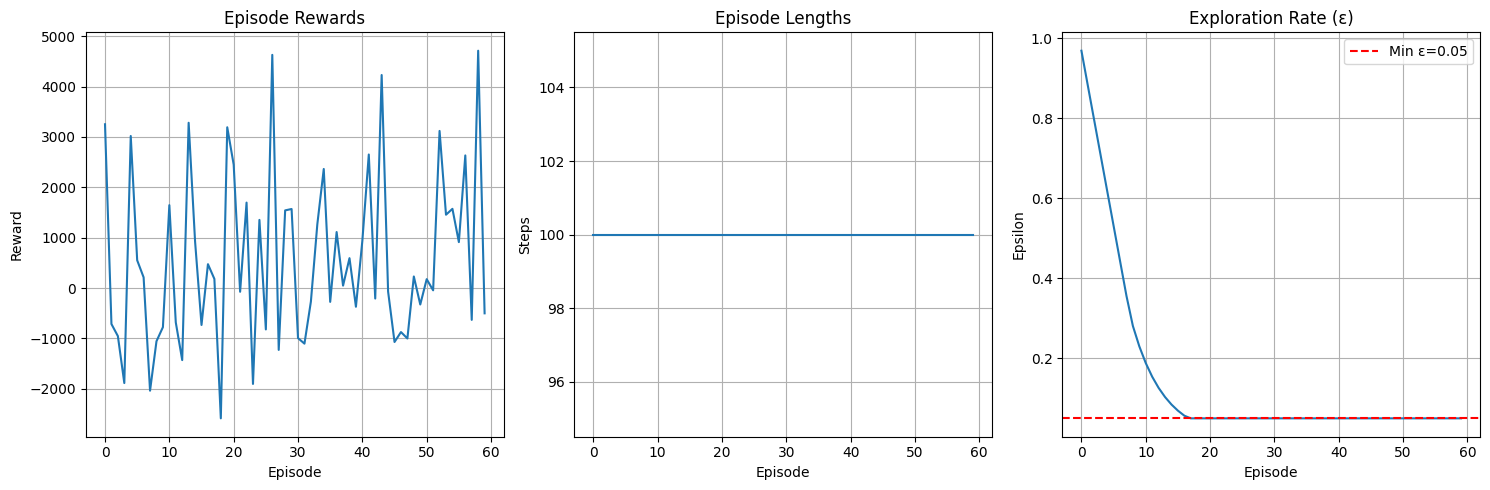

In [6]:
def print_policy_info():
    """Print detailed policy information"""
    print("\n" + "="*60)
    print("🤖 RL TRAFFIC MANAGEMENT POLICY DETAILS")
    print("="*60)
    
    print("\n📊 STATE SPACE (per junction):")
    print("  • Vehicle Counts: [North, South, East, West] (4 values)")
    print("  • Queue Lengths: [North, South, East, West] (4 values)")
    print("  • Time of Day: Normalized 0-1 (1 value)")
    print("  • Traffic Density: Normalized 0-1 (1 value)")
    print("  • Weather: One-hot [Clear, Rain, Fog, Snow, Storm] (5 values)")
    print("  ➤ Total per junction: 15 features")
    print("  ➤ For N junctions: 15×N features")
    
    print("\n🎯 ACTION SPACE:")
    print("  9 Signal Timing Combinations:")
    print("    0: (20s NS, 40s EW)  1: (25s NS, 35s EW)  2: (30s NS, 30s EW)")
    print("    3: (35s NS, 25s EW)  4: (40s NS, 20s EW)  5: (45s NS, 45s EW)")
    print("    6: (50s NS, 40s EW)  7: (55s NS, 35s EW)  8: (60s NS, 30s EW)")
    
    print("\n🧠 NEURAL NETWORK ARCHITECTURE:")
    print("  • Input Layer: State size (15×N neurons)")
    print("  • Hidden Layer 1: 128 neurons + BatchNorm + Dropout(0.3)")
    print("  • Hidden Layer 2: 64 neurons + BatchNorm + Dropout(0.3)")
    print("  • Hidden Layer 3: 32 neurons + Dropout(0.2)")
    print("  • Output Layer: 9 neurons (Q-values for actions)")
    print("  • Activation: ReLU (hidden), Linear (output)")
    print("  • Loss Function: Huber Loss")
    print("  • Optimizer: Adam (lr=0.0005)")
    
    print("\n🔄 TRAINING ALGORITHM:")
    print("  • Algorithm: Double Deep Q-Network (DDQN)")
    print("  • Experience Replay: 10,000 memory buffer")
    print("  • Batch Size: 64")
    print("  • Target Network: Soft updates (τ=0.005)")
    print("  • Discount Factor (γ): 0.95")
    
    print("\n🎲 EXPLORATION STRATEGY:")
    print("  • Policy: Improved ε-greedy")
    print("  • Initial ε: 1.0 (100% exploration)")
    print("  • Minimum ε: 0.05 (5% exploration)")
    print("  • Decay: Linear for 200 steps, then exponential (0.998)")
    print("  • Maintains exploration throughout training")
    
    print("\n🏆 REWARD FUNCTION:")
    print("  • Throughput: +0.5 × total_vehicles")
    print("  • Queue Penalty: -1.0 × total_queue_length")
    print("  • Density Penalty: -0.1 × traffic_density")
    print("  • Timing Efficiency: +10 (optimal signal timing)")
    print("  • Weather Penalty: -5.0 (adverse conditions)")
    print("  • Rush Hour Bonus: 1.5× multiplier")
    
    print("="*60 + "\n")


# Main execution
if __name__ == "__main__":
    print_policy_info()
    
    # Load dataset
    try:
        df = pd.read_csv(r'C:\Users\yashg\Desktop\SIH25\files\mumbai_traffic_dataset.csv')
        print(f"📊 Dataset loaded: {len(df)} traffic records")
        
        # Train enhanced model with cross-validation and minimum green time
        trained_agent, rewards, lengths, epsilons, cv_scores = train_enhanced_rl_with_cv(
            df, episodes=60, n_junctions=2, min_green_time=15, cv_folds=3
        )
        
        # Visualization
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.plot(rewards)
        plt.title('Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.grid(True)
        
        plt.subplot(1, 3, 2)
        plt.plot(lengths)
        plt.title('Episode Lengths')
        plt.xlabel('Episode')
        plt.ylabel('Steps')
        plt.grid(True)
        
        plt.subplot(1, 3, 3)
        plt.plot(epsilons)
        plt.title('Exploration Rate (ε)')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon')
        plt.grid(True)
        plt.axhline(y=0.05, color='r', linestyle='--', label='Min ε=0.05')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        
    except FileNotFoundError:
        print("❌ Dataset file not found! Please check the file path.")

In [7]:
import traci
import os

# Path to your SUMO binary (update if different)
sumo_binary = r"C:\Program Files (x86)\Eclipse\Sumo\bin\sumo.exe"

# Your SUMO config file
sumo_config = r"C:\Users\yashg\Desktop\SIH25\mumbai\sumo\osm.sumocfg"

if os.path.exists(sumo_config):
    try:
        # Start SUMO with full path
        traci.start([sumo_binary, "-c", sumo_config])
        
        # Get all traffic light IDs
        tl_ids = traci.trafficlight.getIDList()
        print(f"Traffic lights found: {len(tl_ids)}")
        print("Traffic light IDs:", tl_ids)

        # Example: Get info for first traffic light
        if tl_ids:
            first_tl = tl_ids[0]
            print(f"\nDetails for {first_tl}:")
            print(f"Current phase: {traci.trafficlight.getPhase(first_tl)}")
            print(f"Phase duration: {traci.trafficlight.getPhaseDuration(first_tl)}s")

    except Exception as e:
        print(f"Error: {e}")
    finally:
        traci.close()
else:
    print(f"Config file not found: {sumo_config}")


Traffic lights found: 22
Traffic light IDs: ('1468337691', '2629418499', '471566319', 'GS_cluster_471591707_5353822010', 'cluster_10089667078_10089667079_346644272_7206407288', 'cluster_10272736790_1936355361_2629418478_296362019_#1more', 'cluster_10273014622_245664667', 'cluster_10770749309_10921550007_346633203', 'cluster_10882715558_10882715559_10882727459_6072223940', 'cluster_10882727464_10882727465_4328035970_9916444554', 'cluster_12373493651_347106948_9681688981_9681689002', 'cluster_1936355393_471554800', 'cluster_1936355394_245667457', 'cluster_2629418501_347194070_9979171948_9979171957', 'cluster_346633216_9681688983', 'cluster_347115324_5353822012', 'cluster_347149014_4310550234', 'cluster_4328035957_9739950371_9739950372_9739950373', 'cluster_5887563939_5887563940', 'joinedS_10603240106_10603240107_cluster_10603240108_10603240109', 'joinedS_1936355384_2244797448_cluster_245667153_9979171956_9979171964_9979171965', 'joinedS_2629418495_cluster_10878501990_10878501991_34717614

In [8]:
class SUMOTrafficEnvironment:
    def __init__(self, sumo_config):
        self.sumo_config = sumo_config
        traci.start(["sumo", "-c", sumo_config])
    
    def apply_rl_action(self, junction_id, action):
        # Convert RL action to signal timing
        ns_green, ew_green = self.action_to_timing(action)
        
        # Apply to SUMO
        traci.trafficlight.setPhaseDuration(junction_id, ns_green)
        # Switch to EW phase
        traci.trafficlight.setPhase(junction_id, 1)
        traci.trafficlight.setPhaseDuration(junction_id, ew_green)
    
    def get_traffic_state(self, junction_id):
        # Get real-time traffic data from SUMO
        vehicle_count = traci.junction.getLastStepVehicleNumber(junction_id)
        waiting_time = traci.junction.getWaitingTime(junction_id)
        return vehicle_count, waiting_time
